In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils import data

from datasets import *

In [2]:
class FC(nn.Module): 
    def __init__(self, input_dim, input_len, hidden_dim, output_dim): 
        super(FC, self).__init__()
        self.input_dim = input_dim
        self.input_len = input_len
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(input_len * input_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, output_dim) 
        )
    
    def forward(self, x, output_length): 
#         x = x.permute(0, 2, 1).float().to(device)
        x = x.reshape(x.shape[0], -1) 

        outputs = []
        for i in range(output_length): 
            out = self.fc(x)
            xx = torch.cat([x[:, self.input_dim:], out], dim = 1)  
            outputs.append(out)
#             print(out.shape)
        outputs = torch.cat(outputs, dim = 1)
        outputs = outputs.reshape((x.shape[0], 3, 12, -1))
        return outputs

In [50]:
import torch.nn.functional as F 

class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers, dropout_rate = 0):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            dropout = dropout_rate, batch_first = True)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        outputs, hidden = self.lstm(x)
        return outputs, hidden
    
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate = 0):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers = num_layers, 
                            dropout = dropout_rate, batch_first = True)
        
        self.out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)   
        prediction = self.out(output.float())
        return prediction, hidden   

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, hidden_dim, num_layers):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim = input_dim, embedding_dim = embedding_dim, hidden_dim = hidden_dim, num_layers = num_layers).to(device)
        self.decoder = Decoder(output_dim = output_dim, hidden_dim = hidden_dim, num_layers = num_layers).to(device)
        self.output_dim = output_dim
            
    def forward(self, x, target_length):
        batch_size = x.size(0) 
        input_length = x.size(2) 
        x = x.permute(0, 2, 1, 3)
        x = x.reshape((batch_size, input_length, -1))
        
        output_dim = self.decoder.output_dim
        encoder_output, encoder_hidden = self.encoder(x)

        decoder_output = torch.zeros((batch_size, 1, output_dim), device = device)
        decoder_hidden = encoder_hidden
        
        outputs = []
        for t in range(target_length):  
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden)
            outputs.append(decoder_output)
        out = torch.cat(outputs, dim = 1) 
        out = out.reshape((batch_size, target_length, 3, -1))
        out = out.permute((0, 2, 1, 3))
        return out

In [2]:
from torchdiffeq import odeint

class Latent_ODE(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20, rhidden = 20, aug = False, aug_dim = 2):
        super(Latent_ODE, self).__init__()
        self.aug = aug
        self.aug_dim = aug_dim
        if self.aug:
            self.rec = RecognitionRNN(latent_dim, obs_dim+aug_dim, rhidden)
        else:
            self.rec = RecognitionRNN(latent_dim, obs_dim, rhidden)
    
        self.func = LatentODEfunc(latent_dim, nhidden)
        self.dec = LatentODEDecoder(latent_dim, obs_dim, nhidden)
        
    def forward(self, x, output_length):
        time_steps = torch.arange(0, output_length, 0.01).float().to(device)[:output_length] 
        batch_size = x.size(0) 
        input_length = x.size(2)
        x = x.permute(0, 2, 1, 3)
        x = x.reshape((batch_size, input_length, -1))
        if self.aug:
            aug_ten = torch.zeros(x.shape[0], x.shape[1], self.aug_dim).float().to(device)
            x = torch.cat([x, aug_ten], dim = -1)
#         print(xx.shape)
#         print(torch.flip(xx, [1]).shape)
        z0 = self.rec.forward(torch.flip(x, [1]))
        pred_z = odeint(self.func, z0, time_steps).permute(1, 0, 2)
        out = self.dec(pred_z)
#         print(out.shape)
        out = out.reshape((batch_size, output_length, 3, -1))
        out = out.permute((0, 2, 1, 3))
        return out  
    
class LatentODEfunc(nn.Module):
    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, latent_dim)
        )
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.model(x)
        return out
    
class RecognitionRNN(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.model = nn.GRU(obs_dim, nhidden, batch_first = True)
        self.linear = nn.Linear(nhidden, latent_dim)

    def forward(self, x):
        #h0 = torch.zeros(1, x.shape[0], self.nhidden).to(device)
        output, hn = self.model(x)#, h0
        return self.linear(hn[0])
    
class LatentODEDecoder(nn.Module):
    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(LatentODEDecoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, obs_dim)
        )
        
    def forward(self, z):
        out = self.model(z)
        return out 

In [ ]:
class Neural_LWR_sparse2_3cmp(nn.Module):
    def __init__(self, nx, dx, dt, kj, vf, xi, tskip, plm = "none", initial='random', boundary='zeros',
                fix_vf=False, parstep=1):
        self.nx = nx
        #xi are the locations along distance where data is available
        self.xi = xi
        self.tskip = tskip 
            
        super(Neural_LWR_sparse2_3cmp, self).__init__()
        
        self.cmps=["k","q","u"]  #density, flow, velocity
#         self.initial={}
#         self.boundary={}
        
        self.initial = initial # shape: [batch, 3, # sensors]
        self.boundary = boundary # shape: [batch, seq_len, 3]
#         if initial == 'random':
#             self.initial["u"] = torch.nn.Parameter(torch.rand(nx))
#             self.initial["k"] = torch.nn.Parameter(torch.rand(nx))
#             self.initial["q"] = self.initial["k"] * self.initial["v"]
#         elif initial == 'zeros':
#             for c in self.cmps: 
#                 self.initial[c] = torch.zeros(nx, requires_grad=True).double()
#         else:
#             assert list(initial.keys()) == self.cmps, "initial conditions should be dictionary with k,q and u"
#             for c in self.cmps:
#                 self.initial[c] = torch.tensor(initial[c])
            
#         # influx at upstream border - needs to be known or assumed
#         if boundary == 'zeros':
#             for c in self.cmps:
#                 self.boundary[c] = torch.zeros(nt, requires_grad=True).double()
#         else:
#             assert list(boundary.keys()) == self.cmps, "boundary conditions should be dictionary with u,k and q"
#             for c in self.cmps:
#                 self.boundary[c] = torch.tensor(boundary[c])
            
        #factor by which parameter resolution is reduced with respect to nx
        self.parstep=parstep
        
        # use piecewise linear function for kj
        if plm == "none": 
            self.kappa = torch.nn.Parameter(torch.tensor(kj[::self.parstep]), requires_grad=True)
        elif plm == "initial": 
            self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx) 
        else: 
            self.plm = plm
        
        #characteristic velocity vf
        if not fix_vf:
            self.vf=torch.nn.Parameter(torch.tensor(vf[::self.parstep]), requires_grad=True)
#             self.plm = PiecewiseLinearModel(n_breaks = 2, num_regions = self.nx, x = vf)
        else:
            self.vf=torch.tensor(vf[::self.parstep])
        
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
        
    def forward(self, tsteps):
        nt=len(tsteps) 

#         t = torch.linspace(0, 1, nt).repeat(self.nx, 1)
#         kappa = self.plm(t)
#         self.k=[self.initial["k"]]   # density
#         self.u=[self.initial["u"]]   # velocity
#         self.q=[self.initial["q"]]   # flow 
        batch_size = self.initial.shape[0]
        self.k = [self.initial[:, 0]]
        self.q = [self.initial[:, 1]]
        self.u = [self.initial[:, 2]]
        
        #initial values at output points
        self.ki=[self.initial[:, 0][self.xi]]
        self.ui=[self.initial[:, 1][self.xi]]
        self.qi=[self.initial[:, 2][self.xi]]
        
        for n in range(1,nt):
            #This corresponds to the upwind scheme according to Gaddam et al. (2015).
            nk=torch.zeros((batch_size, nx), requires_grad=True).double()
            nu=torch.zeros((batch_size, nx), requires_grad=True).double()
            nq=torch.zeros((batch_size, nx), requires_grad=True).double()
            
            #new values for 3 variables stored in one tensor per time step
            nk[:, 0] = self.boundary[:, n, 0]
            nq[:, 0] = self.boundary[:, n, 1]
            nu[:, 0] = self.boundary[:, n, 2]
                                  
            #full-resolution tensor hkappa and hv1, from down-sampled versions
            idx=torch.arange(self.nx) / self.parstep
            hkappa=self.kappa[idx.long()] #.repeat(batch_size, 1)
#             hkappa = kappa[:, n - 1]
#             print(hkappa.shape)
#             hvf=self.vf[idx.long()] #.repeat(batch_size, 1)
#             hvf = vf[:, n - 1]
            
#             print(self.q[n-1][0], nq[0]) 
            ### 
            # Method of lines + RK4 method 
            # dt * f(t[n], y[n]) 
#             k1_k = - (self.q[n-1][2:] - self.q[n-1][:-2]) / (2 * self.dx) # central difference 
            k1_k = - (self.q[n-1][:, 1:] - self.q[n-1][:, :-1]) / self.dx # finite difference 

            nk_1 = torch.cat((nk[:, 0].unsqueeze(1), self.k[n-1][:, 1:] + k1_k / 2 * self.dt), dim = 1) 
            nu_1 = hvf[1:] * (1 - nk_1[:, 1:] / hkappa[1:]) 
            nq_1 = nk_1[:, 1:] * nu_1
            nq_1 = torch.cat((nq[:, 0].unsqueeze(1), nq_1)) 

            # dt * f(t[n] + dt/2, y[n] + k1/2)  
            k2_k = - (nq_1[:, 1:] - nq_1[:, :-1]) / self.dx
            nk_2 = torch.cat((nk[:, 0].unsqueeze(1), self.k[n-1][:, 1:] + k2_k / 2 * self.dt), dim = 1) 
            nu_2 = hvf[1:] * (1 - nk_2[:, 1:] / hkappa[1:])
            nq_2 = nk_2[:, 1:] * nu_2 
            nq_2 = torch.cat((nq[:, 0].unsqueeze(1), nq_2)) 
            
            k3_k = - (nq_2[:, 1:] - nq_2[:, :-1]) / self.dx 
            nk_3 = torch.cat((nk[:, 0].unsqueeze(1), self.k[n-1][:, 1:] + k3_k * self.dt)) 
            nu_3 = hvf[1:] * (1 - nk_3[:, 1:] / hkappa[1:])
            nq_3 = nk_3[:, 1:] * nu_3 
            nq_3 = torch.cat((nq[:, 0].unsqueeze(1), nq_3)) 

            # dt * f(t[n] + dt, y[n] + k3) 
            k4_k = - (nq_3[:, 1:] - nq_3[:, :-1]) / self.dx
            nk[1:] += self.k[n-1][:, 1:] + 1/6 * (k1_k + 2 * k2_k + 2 * k3_k + k4_k) * self.dt 
            nu[1:] += hvf[1:] * (1 - nk[:, 1:] / hkappa[:, 1:]) 
            nq[1:] += nk[:, 1:] * nu[:, 1:] 

            self.k.append(nk)
            self.u.append(nu)
            self.q.append(nq)
#             print(nk)
#             print(nu)
#             print(nq)
#             print(nk.shape)
            #only output every tskip timesteps
            if (n % self.tskip) == 0:
                self.ki.append(nk[self.xi])
                self.ui.append(nu[self.xi])
                self.qi.append(nq[self.xi])
           
        return torch.stack([torch.stack(self.ki),torch.stack(self.qi),torch.stack(self.ui)])

### Data for time

In [3]:
training_data = torch.load("training_time.pt").float()
test_data = torch.load("test_time.pt").float()

training_set = Dataset(training_data)
test_set = Dataset(test_data)
training_set, val_set = data.random_split(training_set, [int(len(training_set) * 0.875), int(len(training_set) * 0.125)])

#### Normalization 

In [4]:
training_data.shape, test_data.shape

(torch.Size([44400, 3, 24, 80]), torch.Size([8856, 3, 24, 80]))

In [5]:
data1 = torch.cat((training_data, test_data), dim = 0)
data_np = np.array(data1)

In [6]:
mean = torch.tensor([data_np[:, 0, :, :].mean(), data_np[:, 1, :, :].mean(), data_np[:, 2, :, :].mean()])
std = torch.tensor([data_np[:, 0, :, :].std(), data_np[:, 1, :, :].std(), data_np[:, 2, :, :].std()])
data_norm = torch.zeros(data_np.shape, dtype = torch.float) 
data_norm[:, 0, :, :] = (data1[:, 0, :, :] - mean[0]) / std[0]
data_norm[:, 1, :, :] = (data1[:, 1, :, :] - mean[1]) / std[1]
data_norm[:, 2, :, :] = (data1[:, 2, :, :] - mean[2]) / std[2]

In [7]:
data_norm.shape

torch.Size([53256, 3, 24, 80])

In [8]:
data_norm[1, 0]

tensor([[-0.9438, -0.9939, -0.9917,  ..., -0.8835, -0.8501, -0.8427],
        [-0.9232, -0.9814, -0.9703,  ..., -0.9263, -0.8627, -0.8454],
        [-0.9619, -0.9880, -0.9853,  ..., -0.9368, -0.8046, -0.8556],
        ...,
        [-0.9932, -1.0236, -1.0096,  ..., -0.9724, -0.9206, -0.9441],
        [-0.9891, -1.0241, -1.0206,  ..., -0.9704, -0.9108, -0.9473],
        [-1.0120, -1.0367, -1.0234,  ..., -0.9601, -0.9142, -0.9507]])

In [9]:
mean, std

(tensor([ 0.0346,  0.8775, 28.5914]), tensor([0.0333, 0.6063, 4.1726]))

In [10]:
training_set = Dataset(data_norm[:44400])
test_set = Dataset(data_norm[44400:])
training_set, val_set = data.random_split(training_set, [int(len(training_set) * 0.875), int(len(training_set) * 0.125)])

In [11]:
print(len(training_set))
print(len(val_set))
print(len(test_set))

38850
5550
8856


In [12]:
data_norm = torch.zeros(test_data.shape, dtype = torch.float) 
test_data[:, 0, :, :] = (test_data[:, 0, :, :] - mean[0]) / std[0]
test_data[:, 1, :, :] = (test_data[:, 1, :, :] - mean[1]) / std[1]
test_data[:, 2, :, :] = (test_data[:, 2, :, :] - mean[2]) / std[2]

#### Dataloader 

In [13]:
test_set = Dataset(test_data)
test_loader = data.DataLoader(test_set, batch_size = 128, shuffle = False)

In [14]:
train_loader = data.DataLoader(training_set, batch_size = 128, shuffle = True)
val_loader = data.DataLoader(val_set, batch_size = 128, shuffle = False)

In [15]:
def train(model, train_loader, optimizer, criterion): 
    preds = []
    trues = []
    mse = [] 
#     count = 0
    model.train()
    for X, y in train_loader: 
#         if count % 5 == 0 : print("running batch", count)
#         count += 1
        X, y = X.to(device), y.to(device)
#         y = y.reshape((y.shape[0], -1))
        pred = model(X, 12) 
        
        loss = 0
        loss = criterion(pred, y)
        mse.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        trues.append(y.cpu().data.numpy())
        preds.append(pred.cpu().data.numpy())
    
    preds = np.concatenate(preds, axis = 0)
    trues = np.concatenate(trues, axis = 0)
    
    return preds, trues, np.mean(mse)

In [16]:
def val(model, val_loader, best_loss, criterion, name): 
    preds = []
    trues = []
    mse = []
    
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
#             y = y.reshape((y.shape[0], -1))
            pred = model(X, 12)
            
            loss = 0
            loss = criterion(pred, y)
            mse.append(loss.item()) 
            
            trues.append(y.cpu().data.numpy())
            preds.append(pred.cpu().data.numpy())

        preds = np.concatenate(preds, axis = 0)
        trues = np.concatenate(trues, axis = 0)
    
    val_loss = np.mean(mse)
    if val_loss <= best_loss: 
        best_loss = val_loss
#             torch.save(model.state_dict(), 'model.pt')
        torch.save(model, name + ".pth")

    return preds, trues, val_loss, best_loss

In [17]:
def val_true(model, val_loader, best_loss, criterion, name): 
    preds = []
    trues = []
    mse = []
    
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            pred = model(X, 12)
            pred[:, 0, :, :] = (pred[:, 0, :, :] * std[0] + mean[0])
            pred[:, 1, :, :] = (pred[:, 1, :, :] * std[1] + mean[1])
            pred[:, 2, :, :] = (pred[:, 2, :, :] * std[2] + mean[2])
                                
            y[:, 0, :, :] = (y[:, 0, :, :] * std[0] + mean[0])
            y[:, 1, :, :] = (y[:, 1, :, :] * std[1] + mean[1])
            y[:, 2, :, :] = (y[:, 2, :, :] * std[2] + mean[2])
            loss = 0
            loss = criterion(pred, y)
            mse.append(loss.item()) 
            
            trues.append(y.cpu().data.numpy())
            preds.append(pred.cpu().data.numpy())

        preds = np.concatenate(preds, axis = 0)
        trues = np.concatenate(trues, axis = 0)
    
    val_loss = np.mean(mse)


    return preds, trues, val_loss, best_loss

In [21]:
input_dim = 3 * 80 
input_len = 12
hidden_dim = 512
output_dim = 3 * 80

device = "cuda"
model = FC(input_dim, input_len, hidden_dim, output_dim).to(device)

In [51]:
device = "cuda"
model = Seq2Seq(input_dim = 3 * 80, embedding_dim = 256, output_dim = 3 * 80, hidden_dim = 512, num_layers = 1).to(device)

In [7]:
device = "cuda"
model = Latent_ODE(latent_dim = 256, obs_dim = 240, nhidden = 256, rhidden = 256, aug = False).to(device)

In [22]:
name = "FC"
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)
criterion = nn.MSELoss()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

best_loss = 100   
train_losses = []
val_losses = []

2648816


In [53]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

Epoch: 1 completed in: 5.6383960247039795s. Training loss: 0.2366814226108162. Val loss: 0.17446700449694286
Epoch: 2 completed in: 5.02957820892334s. Training loss: 0.16155681217481432. Val loss: 0.15604772232472897
Epoch: 3 completed in: 5.027646541595459s. Training loss: 0.14381112121535758. Val loss: 0.1407723089849407
Epoch: 4 completed in: 5.038166761398315s. Training loss: 0.13456907022842451. Val loss: 0.14030628228052097
Epoch: 5 completed in: 4.998900651931763s. Training loss: 0.12890779273584485. Val loss: 0.12695559791543268
0.007737809374999999
Epoch: 6 completed in: 5.066921710968018s. Training loss: 0.12242634253772466. Val loss: 0.12545786476270718
Epoch: 7 completed in: 5.007626056671143s. Training loss: 0.11824067270285205. Val loss: 0.11883871240372007
Epoch: 8 completed in: 5.062180757522583s. Training loss: 0.11483679643194926. Val loss: 0.11911268921738322
Epoch: 9 completed in: 5.072439432144165s. Training loss: 0.11084156454001602. Val loss: 0.11413075334646484


Epoch: 73 completed in: 5.022761821746826s. Training loss: 0.04465727106128868. Val loss: 0.054776296273551205
Epoch: 74 completed in: 5.045770645141602s. Training loss: 0.044398225966448844. Val loss: 0.05465252858332612
Epoch: 75 completed in: 5.0257768630981445s. Training loss: 0.04428143179240195. Val loss: 0.054556530392305416
0.00021343733845877503
Epoch: 76 completed in: 5.058190822601318s. Training loss: 0.04408612457643214. Val loss: 0.0543900468302044
Epoch: 77 completed in: 5.051549673080444s. Training loss: 0.043929239943329444. Val loss: 0.05425691833211617
Epoch: 78 completed in: 5.024392366409302s. Training loss: 0.04380851435033899. Val loss: 0.05417237871072509
Epoch: 79 completed in: 5.109514474868774s. Training loss: 0.04364922253022853. Val loss: 0.05414840553633191
Epoch: 80 completed in: 5.05009388923645s. Training loss: 0.0434985380301154. Val loss: 0.054087264886633915
0.00016515374385013573
Epoch: 81 completed in: 5.043016195297241s. Training loss: 0.0434233104

In [54]:
_, _, val_loss, best_loss = val_true(model, val_loader, best_loss, criterion, name) 

In [55]:
val_loss

0.4899429807608778

In [59]:
_, _, test_loss, best_loss = val_true(model, test_loader, best_loss, criterion, name) 

In [60]:
test_loss

0.7503080221159117

In [120]:
sample = data_norm[1].unsqueeze(dim = 0).to(device)
sample.shape

torch.Size([1, 3, 24, 80])

In [122]:
sample[0, 0, -1]

tensor([-1.0120, -1.0367, -1.0234, -1.0151, -1.0167, -1.0020, -0.8603, -1.0366,
        -0.7483, -0.9782, -0.9445, -0.9412, -0.9398, -0.9197, -0.9352, -0.8993,
        -0.9802, -0.9509, -0.9617, -0.9769, -0.9378,  0.2531, -0.9428, -0.9116,
        -0.9673, -0.9580, -0.9093, -1.0052, -0.9688, -0.9609, -0.9761, -0.9457,
        -0.9855, -0.9818, -0.9926, -0.9093, -1.0037, -1.0000, -0.9782, -0.9310,
        -0.9146, -0.9850, -0.9981, -1.0138, -0.9507, -1.0365, -1.0365, -0.9677,
        -0.9593, -0.9584, -0.9800, -0.9118, -0.9162, -0.8667, -0.9870, -0.9868,
        -0.9496, -0.9653, -0.9729, -0.9662, -0.8962, -0.8402, -0.7919, -0.8443,
        -0.7767, -0.9603, -0.9602, -0.9666, -0.9610, -0.9592, -0.9364, -0.9652,
        -0.9510, -0.9741, -0.9672, -0.8974, -0.9910, -0.9601, -0.9142, -0.9507],
       device='cuda:0')

In [123]:
pred1 = model(sample[:12], 12)

In [124]:
pred1.shape

torch.Size([1, 3, 12, 80])

In [103]:
sam = training_data[1].unsqueeze(dim = 0).to(device)

In [108]:
sam[:, 0, :, :] = (sam[:, 0, :, :] - mean[0]) / std[0]
sam[:, 1, :, :] = (sam[:, 1, :, :] - mean[1]) / std[1]
sam[:, 2, :, :] = (sam[:, 2, :, :] - mean[2]) / std[2]

In [109]:
sam[0, 0]

tensor([[-0.9438, -0.9939, -0.9917,  ..., -0.8835, -0.8501, -0.8427],
        [-0.9232, -0.9814, -0.9703,  ..., -0.9263, -0.8627, -0.8454],
        [-0.9619, -0.9880, -0.9853,  ..., -0.9368, -0.8046, -0.8556],
        ...,
        [-0.9932, -1.0236, -1.0096,  ..., -0.9724, -0.9206, -0.9441],
        [-0.9891, -1.0241, -1.0206,  ..., -0.9704, -0.9108, -0.9473],
        [-1.0120, -1.0367, -1.0234,  ..., -0.9601, -0.9142, -0.9507]],
       device='cuda:0')

In [125]:
pred1[:, 0, :, :] = (pred1[:, 0, :, :] * std[0] + mean[0])
pred1[:, 1, :, :] = (pred1[:, 1, :, :] * std[1] + mean[1])
pred1[:, 2, :, :] = (pred1[:, 2, :, :] * std[2] + mean[2])
                                
sample[:, 0, :, :] = (sample[:, 0, :, :] * std[0] + mean[0])
sample[:, 1, :, :] = (sample[:, 1, :, :] * std[1] + mean[1])
sample[:, 2, :, :] = (sample[:, 2, :, :] * std[2] + mean[2])

In [126]:
criterion(pred1, sample[:, :, 12:])

tensor(0.1827, device='cuda:0', grad_fn=<MseLossBackward>)

In [105]:
criterion(pred1, sam[:, :, 12:])

tensor(1.2652, device='cuda:0', grad_fn=<MseLossBackward>)

In [131]:
sample[0, 0, -1, :]

tensor([0.0009, 0.0001, 0.0006, 0.0008, 0.0008, 0.0013, 0.0060, 0.0001, 0.0097,
        0.0021, 0.0032, 0.0033, 0.0033, 0.0040, 0.0035, 0.0047, 0.0020, 0.0030,
        0.0026, 0.0021, 0.0034, 0.0430, 0.0032, 0.0043, 0.0024, 0.0027, 0.0044,
        0.0012, 0.0024, 0.0026, 0.0021, 0.0031, 0.0018, 0.0019, 0.0016, 0.0044,
        0.0012, 0.0013, 0.0021, 0.0036, 0.0042, 0.0018, 0.0014, 0.0009, 0.0030,
        0.0001, 0.0001, 0.0024, 0.0027, 0.0027, 0.0020, 0.0043, 0.0041, 0.0058,
        0.0018, 0.0018, 0.0030, 0.0025, 0.0022, 0.0025, 0.0048, 0.0067, 0.0083,
        0.0065, 0.0088, 0.0027, 0.0027, 0.0024, 0.0026, 0.0027, 0.0035, 0.0025,
        0.0030, 0.0022, 0.0024, 0.0047, 0.0016, 0.0027, 0.0042, 0.0030],
       device='cuda:0')

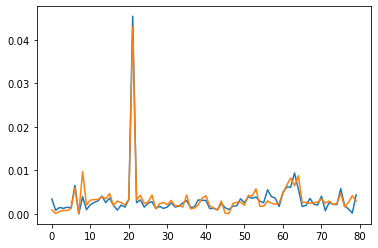

In [127]:
from matplotlib import pyplot as plt

plt.plot(np.arange(80), pred1[0, 0, -1, :].cpu().detach().numpy())
plt.plot(np.arange(80), sample[0, 0, -1, :].cpu().detach().numpy())

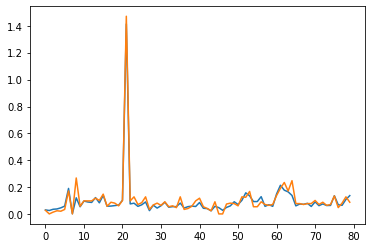

In [129]:
from matplotlib import pyplot as plt

plt.plot(np.arange(80), pred1[0, 1, -1, :].cpu().detach().numpy())
plt.plot(np.arange(80), sample[0, 1, -1, :].cpu().detach().numpy())

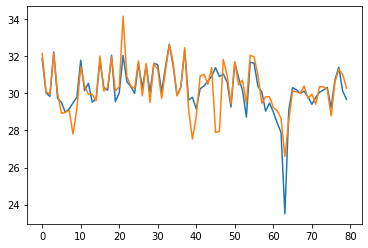

In [130]:
from matplotlib import pyplot as plt

plt.plot(np.arange(80), pred1[0, 2, -1, :].cpu().detach().numpy())
plt.plot(np.arange(80), sample[0, 2, -1, :].cpu().detach().numpy())

In [ ]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

In [23]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

Epoch: 1 completed in: 8.313804864883423s. Training loss: 409.91368660056276. Val loss: 0.9922548248009249
Epoch: 2 completed in: 8.409478664398193s. Training loss: 0.9552405627542421. Val loss: 0.9608251764015718
Epoch: 3 completed in: 7.858785152435303s. Training loss: 0.9416561426692888. Val loss: 0.9519645463336598
Epoch: 4 completed in: 7.829137325286865s. Training loss: 0.9340540572608772. Val loss: 0.9416836215691133
Epoch: 5 completed in: 7.829220294952393s. Training loss: 0.9259938115352079. Val loss: 0.9388267722996798
0.007737809374999999
Epoch: 6 completed in: 7.797724723815918s. Training loss: 0.9225881301650876. Val loss: 0.9246533919464458
Epoch: 7 completed in: 7.9079813957214355s. Training loss: 0.9072769045045501. Val loss: 0.9195777502926913
Epoch: 8 completed in: 7.820415735244751s. Training loss: 0.9017188523552919. Val loss: 0.9144576056437059
Epoch: 9 completed in: 7.830266952514648s. Training loss: 0.8973955829676828. Val loss: 0.9139095707373186
Epoch: 10 compl

Epoch: 75 completed in: 7.497751474380493s. Training loss: 0.8625136535418662. Val loss: 0.8787609176202253
0.00021343733845877503
Epoch: 76 completed in: 7.489464282989502s. Training loss: 0.8627201626567464. Val loss: 0.8787498054179278
Epoch: 77 completed in: 7.573403358459473s. Training loss: 0.8625641920064625. Val loss: 0.8786634017120708
Epoch: 78 completed in: 7.7927985191345215s. Training loss: 0.8627473347281155. Val loss: 0.878494683991779
Epoch: 79 completed in: 7.548799753189087s. Training loss: 0.862122374537744. Val loss: 0.8784645687450062
Epoch: 80 completed in: 7.56614875793457s. Training loss: 0.8624633285952242. Val loss: 0.8784158866513859
0.00016515374385013573
Epoch: 81 completed in: 7.533100128173828s. Training loss: 0.8620813055650184. Val loss: 0.878429498184811
Epoch: 82 completed in: 7.517958641052246s. Training loss: 0.8623767810824671. Val loss: 0.878405594012954
Epoch: 83 completed in: 7.5636913776397705s. Training loss: 0.8617579382109014. Val loss: 0.87

In [24]:
_, _, val_loss, best_loss = val_true(model, val_loader, best_loss, criterion, name) 

In [25]:
val_loss

9.324819705703042

In [27]:
_, _, test_loss, best_loss = val_true(model, test_loader, best_loss, criterion, name) 

In [28]:
test_loss

4.285899019241333

In [9]:
import time

num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)[-1]
    train_losses.append(train_loss)
    _, _, val_loss, best_loss = val(model, val_loader, best_loss, criterion, name) 
    val_losses.append(val_loss)
    best_loss = best_loss
    end = time.time()
    print(f"Epoch: {epoch} completed in: {end - start}s. Training loss: {train_loss}. Val loss: {val_loss}") 
    
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr'])

running batch 0
running batch 5
running batch 10
running batch 15
running batch 20
running batch 25
running batch 30
running batch 35
running batch 40
running batch 45
running batch 50
running batch 55


KeyboardInterrupt: 